# The Ising Model
Here, I'll actually do a symmetric protocol nonequilibrium switch with training... (pray for me)

## Imports

In [1]:
from jax import numpy as jnp
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
from jax import lax, ops, vmap, jit, grad, random, lax

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
from melange_lite.magnets.utils import *
from melange_lite.magnets.ising_modell import IsingsModellSMCMCMCSampler, TrainableIsingsModellSMCSampler

# EXP Protocol MCMC SMC Sampler

In [4]:
N= 248
L=32
T = 20
direction = [0,1]
kT_schedule = jnp.linspace(0,1,T)
IW_parameters = jnp.hstack([jnp.ones(T)[..., jnp.newaxis], #J
                                                                         jnp.zeros(T)[..., jnp.newaxis], #h
                                                                         kT_schedule[..., jnp.newaxis] #beta
                                                                          ])
print(len(IW_parameters))

20


In [5]:
smc_factory = TrainableIsingsModellSMCSampler(T=len(IW_parameters), 
                                              N=N, 
                                              IW_parameters= IW_parameters,
                                              L=L, 
                                              full_scan=True,
                                              MCMC=False
                                              )
smc_work_fn = smc_factory.works()
kernel_kT_schedule = jnp.linspace(0,1,T)[1:]
kernel_kT_schedule_len = len(kernel_kT_schedule)
# kernel_parameters = jnp.hstack([jnp.ones(kernel_kT_schedule_len)[..., jnp.newaxis], #J
#                                 jnp.zeros(kernel_kT_schedule_len)[..., jnp.newaxis], #h
#                                 kernel_kT_schedule[..., jnp.newaxis] #beta
#                                ])

In [6]:
def work_fn(seed, temp_schedule):
    _kernel_parameters = jnp.hstack([jnp.ones(kernel_kT_schedule_len)[..., jnp.newaxis], #J
                                jnp.zeros(kernel_kT_schedule_len)[..., jnp.newaxis], #h
                                temp_schedule[..., jnp.newaxis] #beta
                               ])
    param_dict = {'seed': seed, 'kernel_parameters': _kernel_parameters}
    wks = smc_work_fn(param_dict)
    cumulative_works = jnp.cumsum(wks, axis=0)
    return cumulative_works

In [7]:
seed = random.PRNGKey(45324623)
works = work_fn(seed, kernel_kT_schedule)

In [8]:
works.shape

(20, 248)

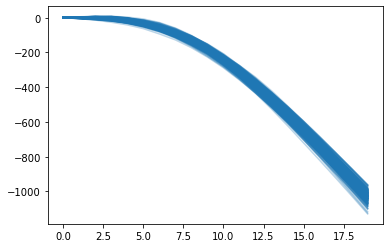

In [9]:
for i in range(N):
    plt.plot(works[:,i], color=colors[0], alpha=0.3)

In [10]:
from melange_lite.utils.analysis import free_energy

In [11]:
def loss_fn(kernel_params, seed):
    cum_works = work_fn(seed, kernel_params)
    last_works = cum_works[-1,:]
    #f = free_energy(last_works)
    f = jnp.mean(last_works)
    return f

    

In [12]:
from jax import value_and_grad
from jax.experimental import optimizers

In [13]:
stepsize=1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size=stepsize)
opt_state = opt_init(kernel_kT_schedule)

In [14]:
@jit
def step(_step, opt_state, seed):
    seed, run_seed = random.split(seed)
    run_seed = seed
    value, grads = value_and_grad(loss_fn)(get_params(opt_state), run_seed)
    new_opt_state = opt_update(_step, grads, opt_state)
    return value, new_opt_state, seed


In [15]:
import tqdm

In [16]:
num_steps=100
seed = random.PRNGKey(42345234523555)

In [17]:
vals = []

In [18]:
for i in tqdm.trange(num_steps):
    value, opt_state, seed = step(i, opt_state, seed)
    vals.append(value)
    

100%|██████████| 100/100 [07:17<00:00,  4.38s/it]


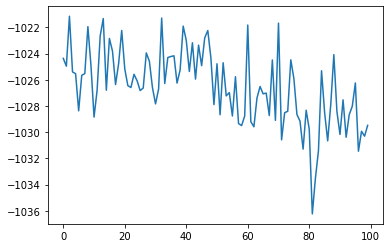

In [19]:
plt.plot(vals)

let's try this another way...

In [57]:
@jit
def man_step(_step, kernel_params, seed, lr):
    #seed, run_seed = random.split(seed)
    run_seed = seed
    value, grads = value_and_grad(loss_fn)(kernel_params, run_seed)
    new_kernel_params = kernel_params - lr*grads
    return value, new_kernel_params, seed

In [58]:
kernel_params = kernel_kT_schedule

In [59]:
vals = []
seed = random.PRNGKey(453245)

In [60]:
for i in tqdm.trange(100):
    val, kernel_params, seed = man_step(i, kernel_params, seed, 1e-12)
    vals.append(val)

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


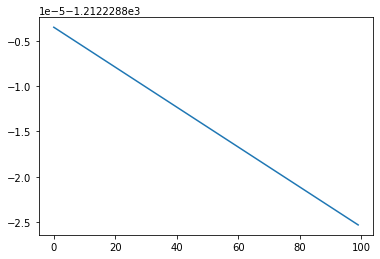

In [61]:
plt.plot(vals)

In [62]:
vals

[DeviceArray(-1212.2288035, dtype=float64),
 Buffer(-1212.22880372, dtype=float64),
 Buffer(-1212.22880394, dtype=float64),
 Buffer(-1212.22880416, dtype=float64),
 Buffer(-1212.22880438, dtype=float64),
 Buffer(-1212.2288046, dtype=float64),
 Buffer(-1212.22880482, dtype=float64),
 Buffer(-1212.22880504, dtype=float64),
 Buffer(-1212.22880526, dtype=float64),
 Buffer(-1212.22880548, dtype=float64),
 Buffer(-1212.22880571, dtype=float64),
 Buffer(-1212.22880593, dtype=float64),
 Buffer(-1212.22880615, dtype=float64),
 Buffer(-1212.22880637, dtype=float64),
 Buffer(-1212.22880659, dtype=float64),
 Buffer(-1212.22880681, dtype=float64),
 Buffer(-1212.22880703, dtype=float64),
 Buffer(-1212.22880725, dtype=float64),
 Buffer(-1212.22880747, dtype=float64),
 Buffer(-1212.22880769, dtype=float64),
 Buffer(-1212.22880791, dtype=float64),
 Buffer(-1212.22880813, dtype=float64),
 Buffer(-1212.22880835, dtype=float64),
 Buffer(-1212.22880857, dtype=float64),
 Buffer(-1212.22880879, dtype=float64